This code is referenced from <br>
https://colab.research.google.com/drive/1igoW8ryWYXDkcAExicaciFvHHFbscHDa

In this tutorial, we will introduce the use of MMpretrain with following content: <br>

1. get a pretrained model and test <br>
2. Prepare demo data <br>
3. Prepare the settings <br>
4. Train and test model <br>

In [1]:
cd mmpretrain

/home/z890/Downloads/ml_sample/classification/mm_Swinv2/mmpretrain


/home/z890/.conda/envs/cmms/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Another Example
Download the dataset from https://www.kaggle.com/datasets/benjaminkz/places365 <br>
Put archive under MMdet/mmpretrain/data <br>
and rename it as 'places365'

In [2]:
# the dataset is very large, we just use the categories that are rooms for demo
import os
import shutil

# Define directories to clean
base_dirs = ['data/places365/train', 'data/places365/val']

for base_dir in base_dirs:
    if not os.path.isdir(base_dir):
        print(f"Directory not found: {base_dir}")
        continue

    for folder in os.listdir(base_dir):
        full_path = os.path.join(base_dir, folder)
        # Check if it's a directory and does NOT contain 'room'
        if os.path.isdir(full_path) and 'room' not in folder.lower():
            print(f"Deleting: {full_path}")
            shutil.rmtree(full_path)

In [3]:
# we use swinv2
from mmpretrain.apis import list_models
list_models(task='Image Classification', pattern='swin')

['swin-base-w6_simmim-100e-pre_8xb256-coslr-100e_in1k-192px',
 'swin-base-w6_simmim-800e-pre_8xb256-coslr-100e_in1k-192px',
 'swin-base-w7_simmim-100e-pre_8xb256-coslr-100e_in1k',
 'swin-base_16xb64_in1k',
 'swin-base_3rdparty_in1k',
 'swin-base_3rdparty_in1k-384',
 'swin-base_in21k-pre-3rdparty_in1k',
 'swin-base_in21k-pre-3rdparty_in1k-384',
 'swin-large-w14_simmim-800e-pre_8xb256-coslr-100e_in1k',
 'swin-large_8xb8_cub-384px',
 'swin-large_in21k-pre-3rdparty_in1k',
 'swin-large_in21k-pre-3rdparty_in1k-384',
 'swin-small_16xb64_in1k',
 'swin-small_3rdparty_in1k',
 'swin-tiny_16xb64_in1k',
 'swin-tiny_3rdparty_in1k',
 'swinv2-base-w16_3rdparty_in1k-256px',
 'swinv2-base-w16_in21k-pre_3rdparty_in1k-256px',
 'swinv2-base-w24_in21k-pre_3rdparty_in1k-384px',
 'swinv2-base-w8_3rdparty_in1k-256px',
 'swinv2-large-w16_in21k-pre_3rdparty_in1k-256px',
 'swinv2-large-w24_in21k-pre_3rdparty_in1k-384px',
 'swinv2-small-w16_3rdparty_in1k-256px',
 'swinv2-small-w8_3rdparty_in1k-256px',
 'swinv2-tin

In [4]:
from mmengine import Config
cfg = Config.fromfile('configs/swin_transformer_v2/swinv2-tiny-w8_16xb64_in1k-256px.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=1024)
bgr_mean = [
    103.53,
    116.28,
    123.675,
]
bgr_std = [
    57.375,
    57.12,
    58.395,
]
data_preprocessor = dict(
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    num_classes=1000,
    std=[
        58.395,
        57.12,
        57.375,
    ],
    to_rgb=True)
dataset_type = 'ImageNet'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=100, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(enable=False, type='VisualizationHook'))
default_scope = 'mmpretrain'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
model = dict(
    backbone=dict(
        arch='tiny',
        drop_path_rate=0.2,
    

In [8]:
cfg.dataset_type = 'CustomDataset'
cfg.data_preprocessor.num_classes = 28
cfg.model.head.num_classes = 28
cfg.default_hooks.checkpoint.interval = 5
cfg.train_cfg.max_epochs = 30
cfg.val_dataloader.batch_size = 160
cfg.val_dataloader.dataset.data_root = 'data/places365'
cfg.val_dataloader.dataset.type = 'CustomDataset'
cfg.val_dataloader.dataset.data_prefix = 'val'
cfg.val_dataloader.dataset.ann_file = None

cfg.test_dataloader = cfg.val_dataloader

cfg.train_dataloader.batch_size = 160
cfg.train_dataloader.dataset.data_root = 'data/places365'
cfg.train_dataloader.dataset.type = 'CustomDataset'
cfg.train_dataloader.dataset.data_prefix = 'train'
cfg.train_dataloader.dataset.ann_file = None

cfg.optim_wrapper.optimizer.lr = 0.001/8

# Delete the split configuration
if hasattr(cfg.test_dataloader.dataset, 'split'):
    delattr(cfg.test_dataloader.dataset, 'split')
if hasattr(cfg.val_dataloader.dataset, 'split'):
    delattr(cfg.val_dataloader.dataset, 'split')
if hasattr(cfg.train_dataloader.dataset, 'split'):
    delattr(cfg.train_dataloader.dataset, 'split')
#------------------------------------------------------
config=f'./configs/swin_transformer_v2/swinv2-tiny-w8_16xb64_in1k-256px_place.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

In [9]:
%run tools/train.py configs/swin_transformer_v2/swinv2-tiny-w8_16xb64_in1k-256px_place.py

05/29 16:16:47 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1143468533
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

KeyboardInterrupt: 

In [10]:
import torch
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Validation
set --out "your location to save a pkl"

In [4]:
import os
from glob import glob

def get_latest_config(base_dir="work_dirs"):
    subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    subdirs.sort(key=os.path.getmtime, reverse=True)  # Sort by Time
    for d in subdirs:
        config = os.path.join(d, "config.py")
        if os.path.exists(config):
            return config
    return None


def get_latest_checkpoint(base_dir="work_dirs"):
    subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    subdirs.sort(key=os.path.getmtime, reverse=True)  # Sort by modification time, newest first

    for d in subdirs:
        ckpt_file = os.path.join(d, "last_checkpoint")
        if os.path.exists(ckpt_file):
            with open(ckpt_file, "r") as f:
                relative_ckpt_path = f.readline().strip()
                full_ckpt_path = os.path.join(d, relative_ckpt_path)
                if os.path.exists(full_ckpt_path):
                    return full_ckpt_path
    return None

latest_config = get_latest_config()
latest_ckpt = get_latest_checkpoint()

print(f"Using config: {latest_config}")
print(f"Using checkpoint: {latest_ckpt}")

Using config: work_dirs/swinv2-tiny-w8_16xb64_in1k-256px_place/config.py
Using checkpoint: /home/z890/Downloads/ml_sample/classification/mm_Swinv2/mmpretrain/work_dirs/swinv2-tiny-w8_16xb64_in1k-256px_place/epoch_5.pth


In [5]:
%run tools/test.py {latest_config} {latest_ckpt} --out output/swinv2-tiny-w8_16xb64_in1k-256px_place.pkl

05/29 17:25:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 642323652
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,cod

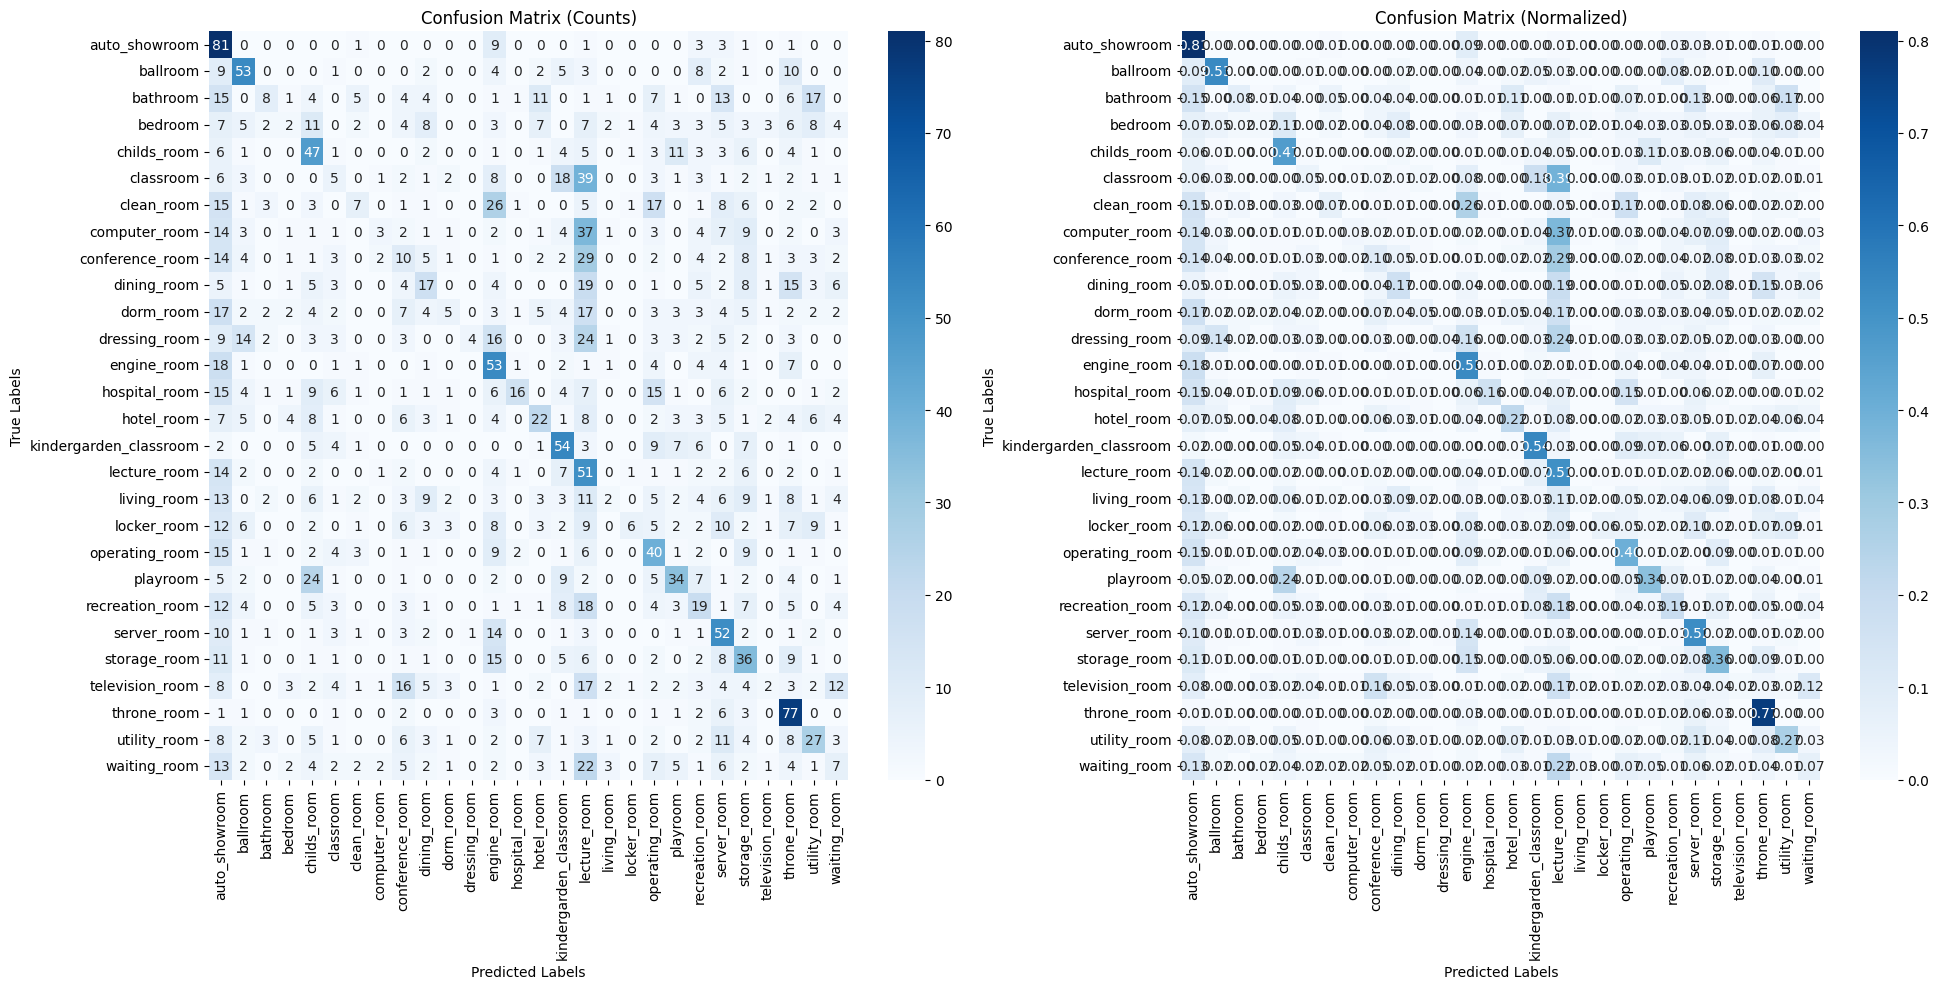

In [10]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Load data from .pkl file
file_path = "output/swinv2-tiny-w8_16xb64_in1k-256px_place.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract ground truth and predicted labels
gt_labels = []
pred_labels = []

for entry in data:
    gt_labels.append(entry['gt_label'].item())  # Convert tensor to int
    pred_labels.append(entry['pred_label'].item())

# Define class names (replace with your actual class names)
class_names = ['auto_showroom', 'ballroom', 'bathroom', 'bedroom', 'childs_room', 'classroom', 'clean_room', 'computer_room', 
               'conference_room', 'dining_room', 'dorm_room', 'dressing_room', 'engine_room', 'hospital_room', 'hotel_room', 
               'kindergarden_classroom', 'lecture_room', 'living_room', 'locker_room', 'operating_room', 'playroom', 'recreation_room', 
               'server_room', 'storage_room', 'television_room', 'throne_room', 'utility_room', 'waiting_room']

# Compute confusion matrices
cm = confusion_matrix(gt_labels, pred_labels)
cm_normalized = confusion_matrix(gt_labels, pred_labels, normalize='true')  # Normalized by true labels

# Plot standard confusion matrix
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()